# Tutorial #4 HyperModel Cores

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np

import json, pickle, copy

In [2]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

## Loading Chains

In [3]:
psrname = 'J1713+0747'
chaindir = '/Users/hazboun/software_development/la_forge/tests/data/chains/adv_noise_J1713+0747/'

Us the `core.HyperModelCore` to load up the chains from an `enterprise_extensions.hypermodel.HyperModel` analysis. The code automatically looks for a dictionary containing the parameters in each model at `'./model_params.json'`, but you can also provide one with a keyword argument.

In [4]:
cH=co.HyperModelCore(label=f'PSR {psrname}, DM Model Selection',
                     chaindir=chaindir)

The `HyperModelCore` has most of the same atrributes in the base `Core` class that are useful for looking at the chains.

In [5]:
len(cH.param_dict.keys())

5

Here we return the model with the largest number of samples.

In [6]:
vals,bins=np.histogram(cH.get_param('nmodel'),
                       bins=[-0.5+ii for ii in range(len(cH.param_dict.keys()))])
np.argmax(vals)

0

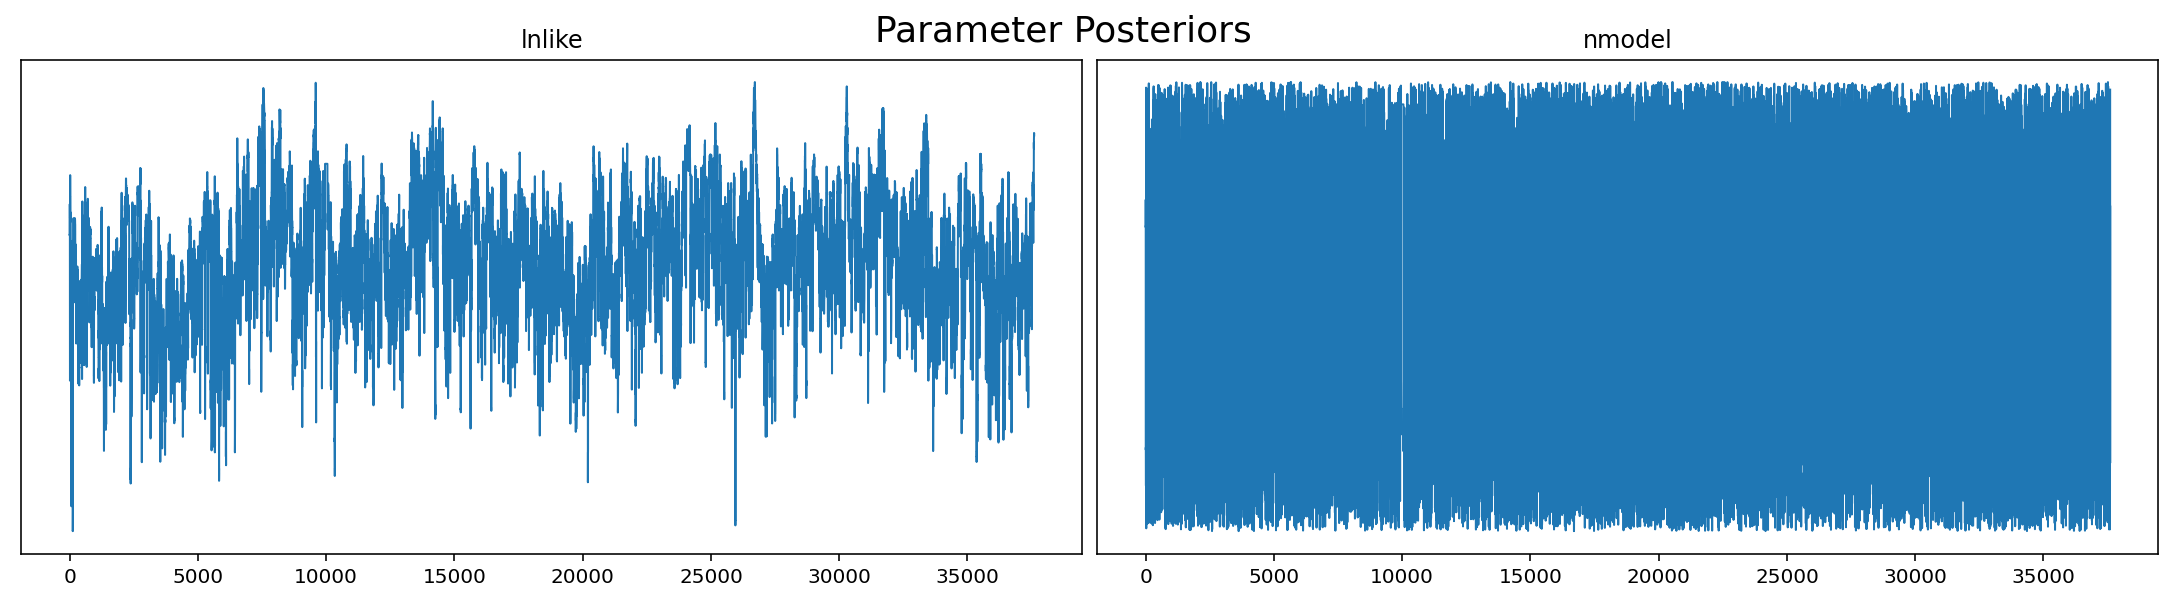

In [7]:
cH.set_burn(3000)
dg.plot_chains(cH,hist=False,pars=['lnlike','nmodel'],ncols=2)

In [8]:
def odds_ratio(nmodel,models=[0,1]):
    top = np.logical_and(nmodel>models[1]-0.5,nmodel<models[1]+0.5)
    bottom = np.logical_and(nmodel>models[0]-0.5,nmodel<models[0]+0.5)
    return np.sum(top)/np.sum(bottom)

In [10]:
odds_ratio(cH('nmodel'),models=[0,2])

0.9796767230032117

### Noise Flower Plots
One useful figure we look at for model selection anlayses is a radial histogram that plots the time spent in each of the possible models. We call these "noise flowers". 

Running advanced noise analysis tools leads to a set of labels being saved for the models being analyzed in a given chain directory under `'model_labels.json'`. This is a list of labels that should help us keep track of the various models being analyzed. If these are not descriptive enough, feel free to edit the nested list. 

One can construct a list of your choosing as well. 

In [11]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'periodic', True, True, True, 'periodic', 4],
 ['B', 'periodic', True, True, True, 'sq_exp', 4],
 ['C', 'periodic', True, True, True, 'periodic', 4.4],
 ['D', 'periodic', True, True, True, 'sq_exp', 4.4],
 ['E', 'periodic', True, True, False, None, None]]

There is a `noise_flower` function in `la_forge.diagnostics` that takes as input a `HyperModelCore`, along with various options, in order to fill out the table with useful information about the models being analyzed. 

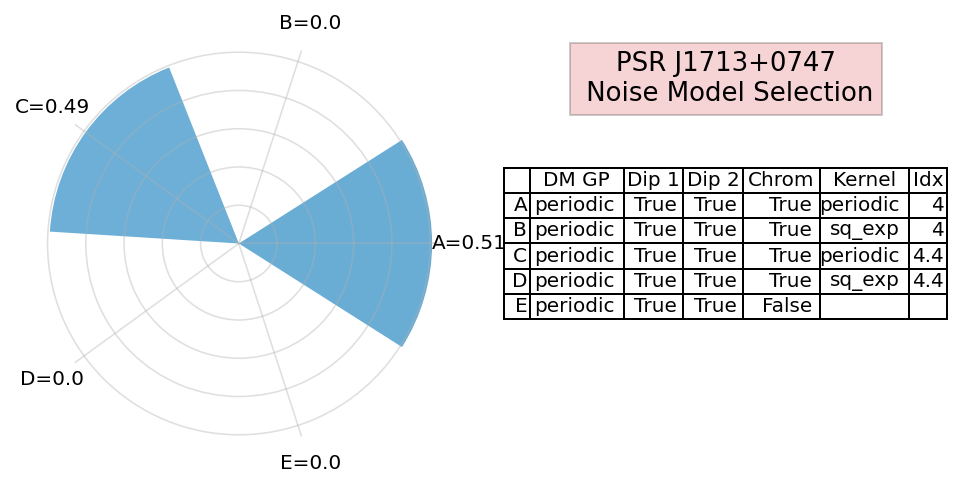

In [12]:
dg.noise_flower(cH, 
                colLabels=['', 'DM GP','Dip 1','Dip 2','Chrom', 'Kernel','Idx'],
                cellText=model_labels,
                colWidths=[0.06,0.22,0.14,0.14,0.18,0.21,0.09])

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model.

The individual cores are pulled out using the `model_core` method and an integer that gives which model you'd like returned.

In [13]:
c0=cH.model_core(0)
c2=cH.model_core(2)

These cores are now individual core instances that can be saved as individual `HDF5` files. 

In [14]:
type(c0)

la_forge.core.Core

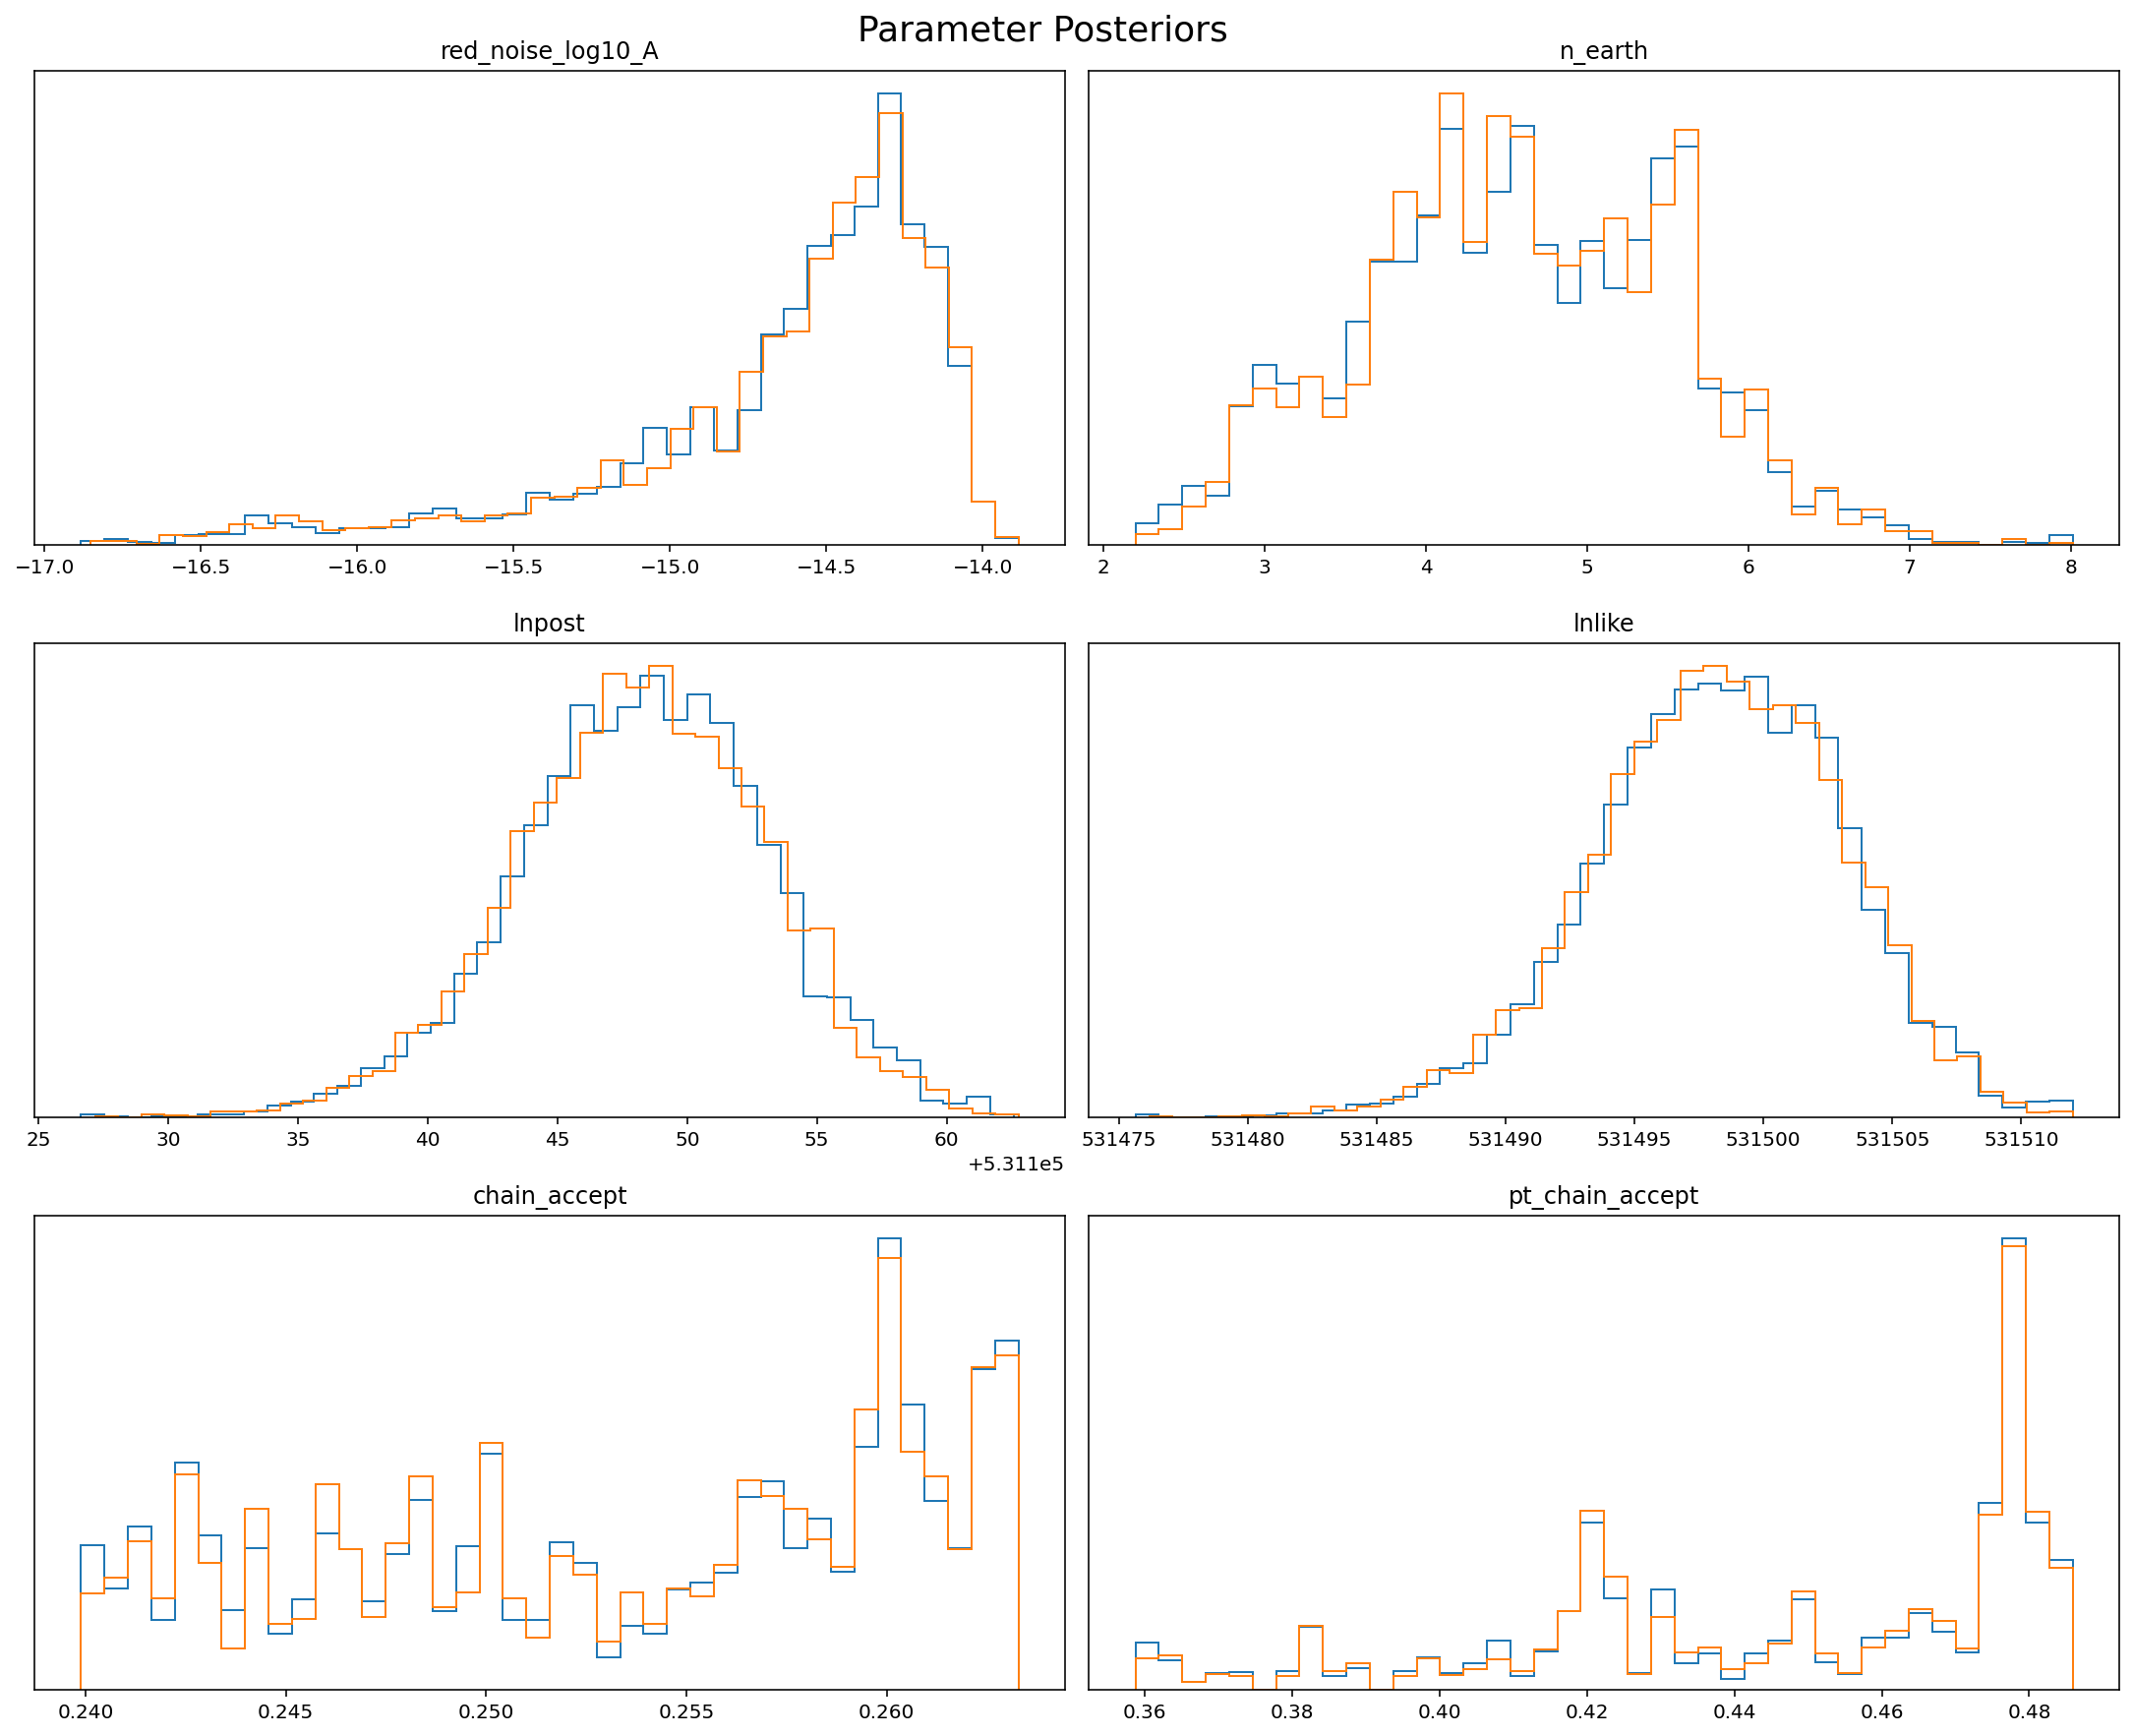

In [15]:
dg.plot_chains([c0,c2],pars=c0.params[-6:],ncols=2)